In [68]:
from seaborn import heatmap
from matplotlib.pyplot import figure, savefig
from pandas import DataFrame
from numpy import ndarray
from requests import get
from time import sleep

%matplotlib inline

In [52]:
def get_markets_ndarray() -> ndarray:
    resp = get('https://api.pro.coinbase.com/products')
    if resp.status_code != 200:
        return None
    else:
        df = DataFrame(resp.json())
        return df[['id']].values

In [53]:
#markets = get_markets_ndarray()
#print (len(markets), markets)

In [54]:
def get_market_data(market: str='BTC-GBP', granularity: int=3600) -> DataFrame:
    resp = get(f'https://api.pro.coinbase.com/products/{market}/candles?granularity={str(granularity)}')
    if resp.status_code != 200:
        raise Exception(format(resp.json()['message']))
    else:
        df = DataFrame(resp.json(), columns=[ 'epoch', 'low', 'high', 'open', 'close', 'volume' ])
        df = df.iloc[::-1].reset_index()
        return df

In [55]:
#market_data = get_market_data('BTC-GBP', 3600)
#print (market_data)

In [56]:
def preprocess_market(market: str='BTC-GBP', granularity: int=3600) -> DataFrame:
    df = get_market_data(market, granularity)
    df['ma1'] = df.close.rolling(50, min_periods=1).mean()
    df['ma2'] = df.close.rolling(200, min_periods=1).mean()
    df['up'] = df['ma1'] > df['ma2']
    df['up'] = df['up'].astype(int)
    df = df[['up']]
    df = df.rename(columns={'up': market})
    return df.T

In [57]:
market_processed = preprocess_market('BTC-GBP', 3600)
print (market_processed)

         0    1    2    3    4    5    6    ...  293  294  295  296  297  298  299
BTC-GBP    0    0    0    0    0    0    0  ...    0    0    0    0    0    0    0

[1 rows x 300 columns]


In [58]:
df = pd.DataFrame()
for market in get_markets_ndarray():
    print ('Processing', market[0])
    
    tmp_df = df.append(preprocess_market(market[0], 3600))
    
    if len(tmp_df.T) == 300:
        df = df.append(preprocess_market(market[0], 3600))
        sleep(0.1) # avoid public rate exceeded

Processing MATIC-GBP
Processing ANKR-USD
Processing WBTC-USD
Processing GRT-USD
Processing FORTH-BTC
Processing XTZ-GBP
Processing ETC-EUR
Processing OMG-EUR
Processing UMA-EUR
Processing ENJ-USD
Processing ICP-EUR
Processing NU-GBP
Processing REP-BTC
Processing LINK-EUR
Processing XTZ-EUR
Processing ICP-BTC
Processing SNX-EUR
Processing YFI-BTC
Processing DAI-USDC
Processing LOOM-USDC
Processing ETC-BTC
Processing OMG-BTC
Processing MATIC-USD
Processing NMR-EUR
Processing ZEC-USDC
Processing BNT-EUR
Processing GRT-EUR
Processing UMA-USD
Processing MIR-USD
Processing ALGO-USD
Processing XLM-EUR
Processing 1INCH-BTC
Processing SNX-GBP
Processing ZEC-BTC
Processing KNC-USD
Processing BAT-USDC
Processing 1INCH-USD
Processing MKR-BTC
Processing SNX-USD
Processing BAL-BTC
Processing ETH-USD
Processing REN-BTC
Processing SOL-GBP
Processing ADA-USDC
Processing ZRX-BTC
Processing OGN-USD
Processing MIR-BTC
Processing ICP-USD
Processing EOS-BTC
Processing NU-USD
Processing ETC-GBP
Processing SK

In [59]:
df.dropna(inplace=True)
df = df.astype(int)

In [60]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
MATIC-GBP,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
ANKR-USD,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
WBTC-USD,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GRT-USD,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
FORTH-BTC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MANA-ETH,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
CGLD-USD,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
CGLD-GBP,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
BTC-EUR,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [61]:
df.to_csv('coinbasepro_market_analysis.csv')

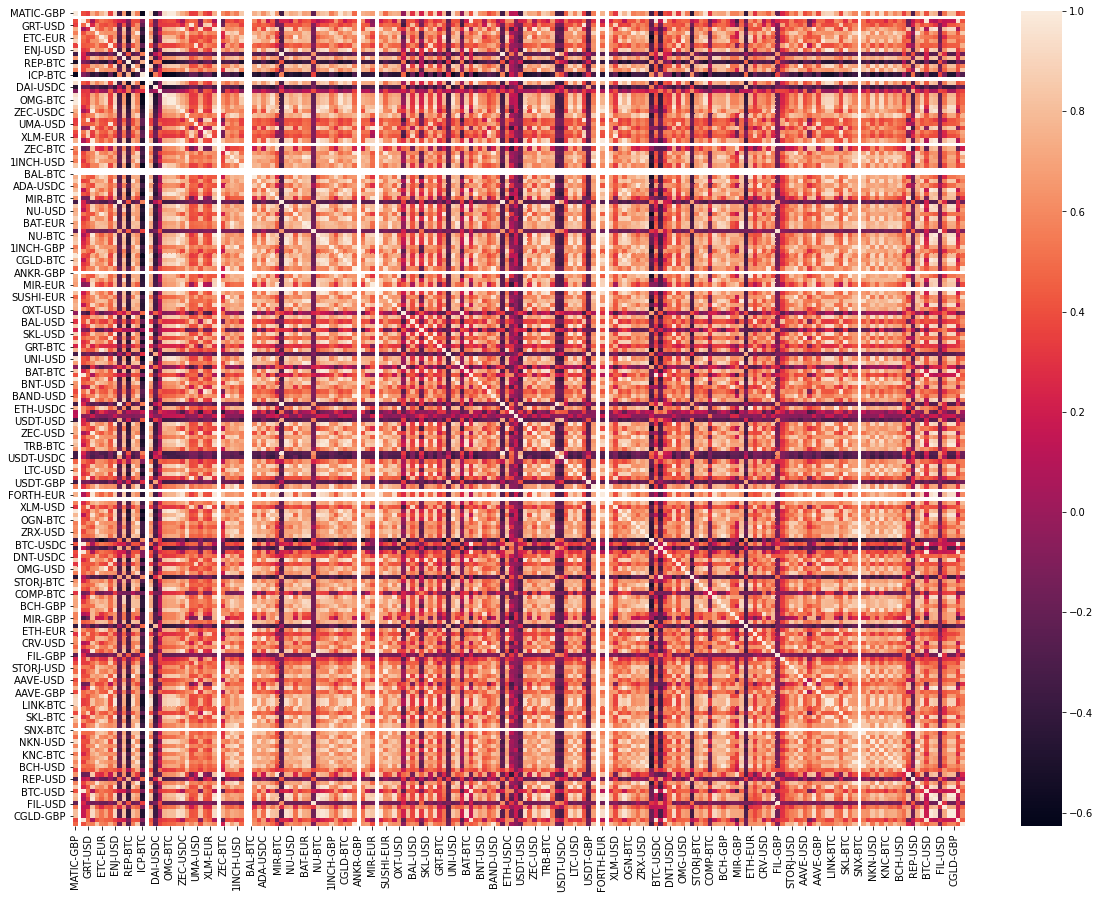

In [62]:
figure(figsize=(20,15))
heatmap(df.T.corr())

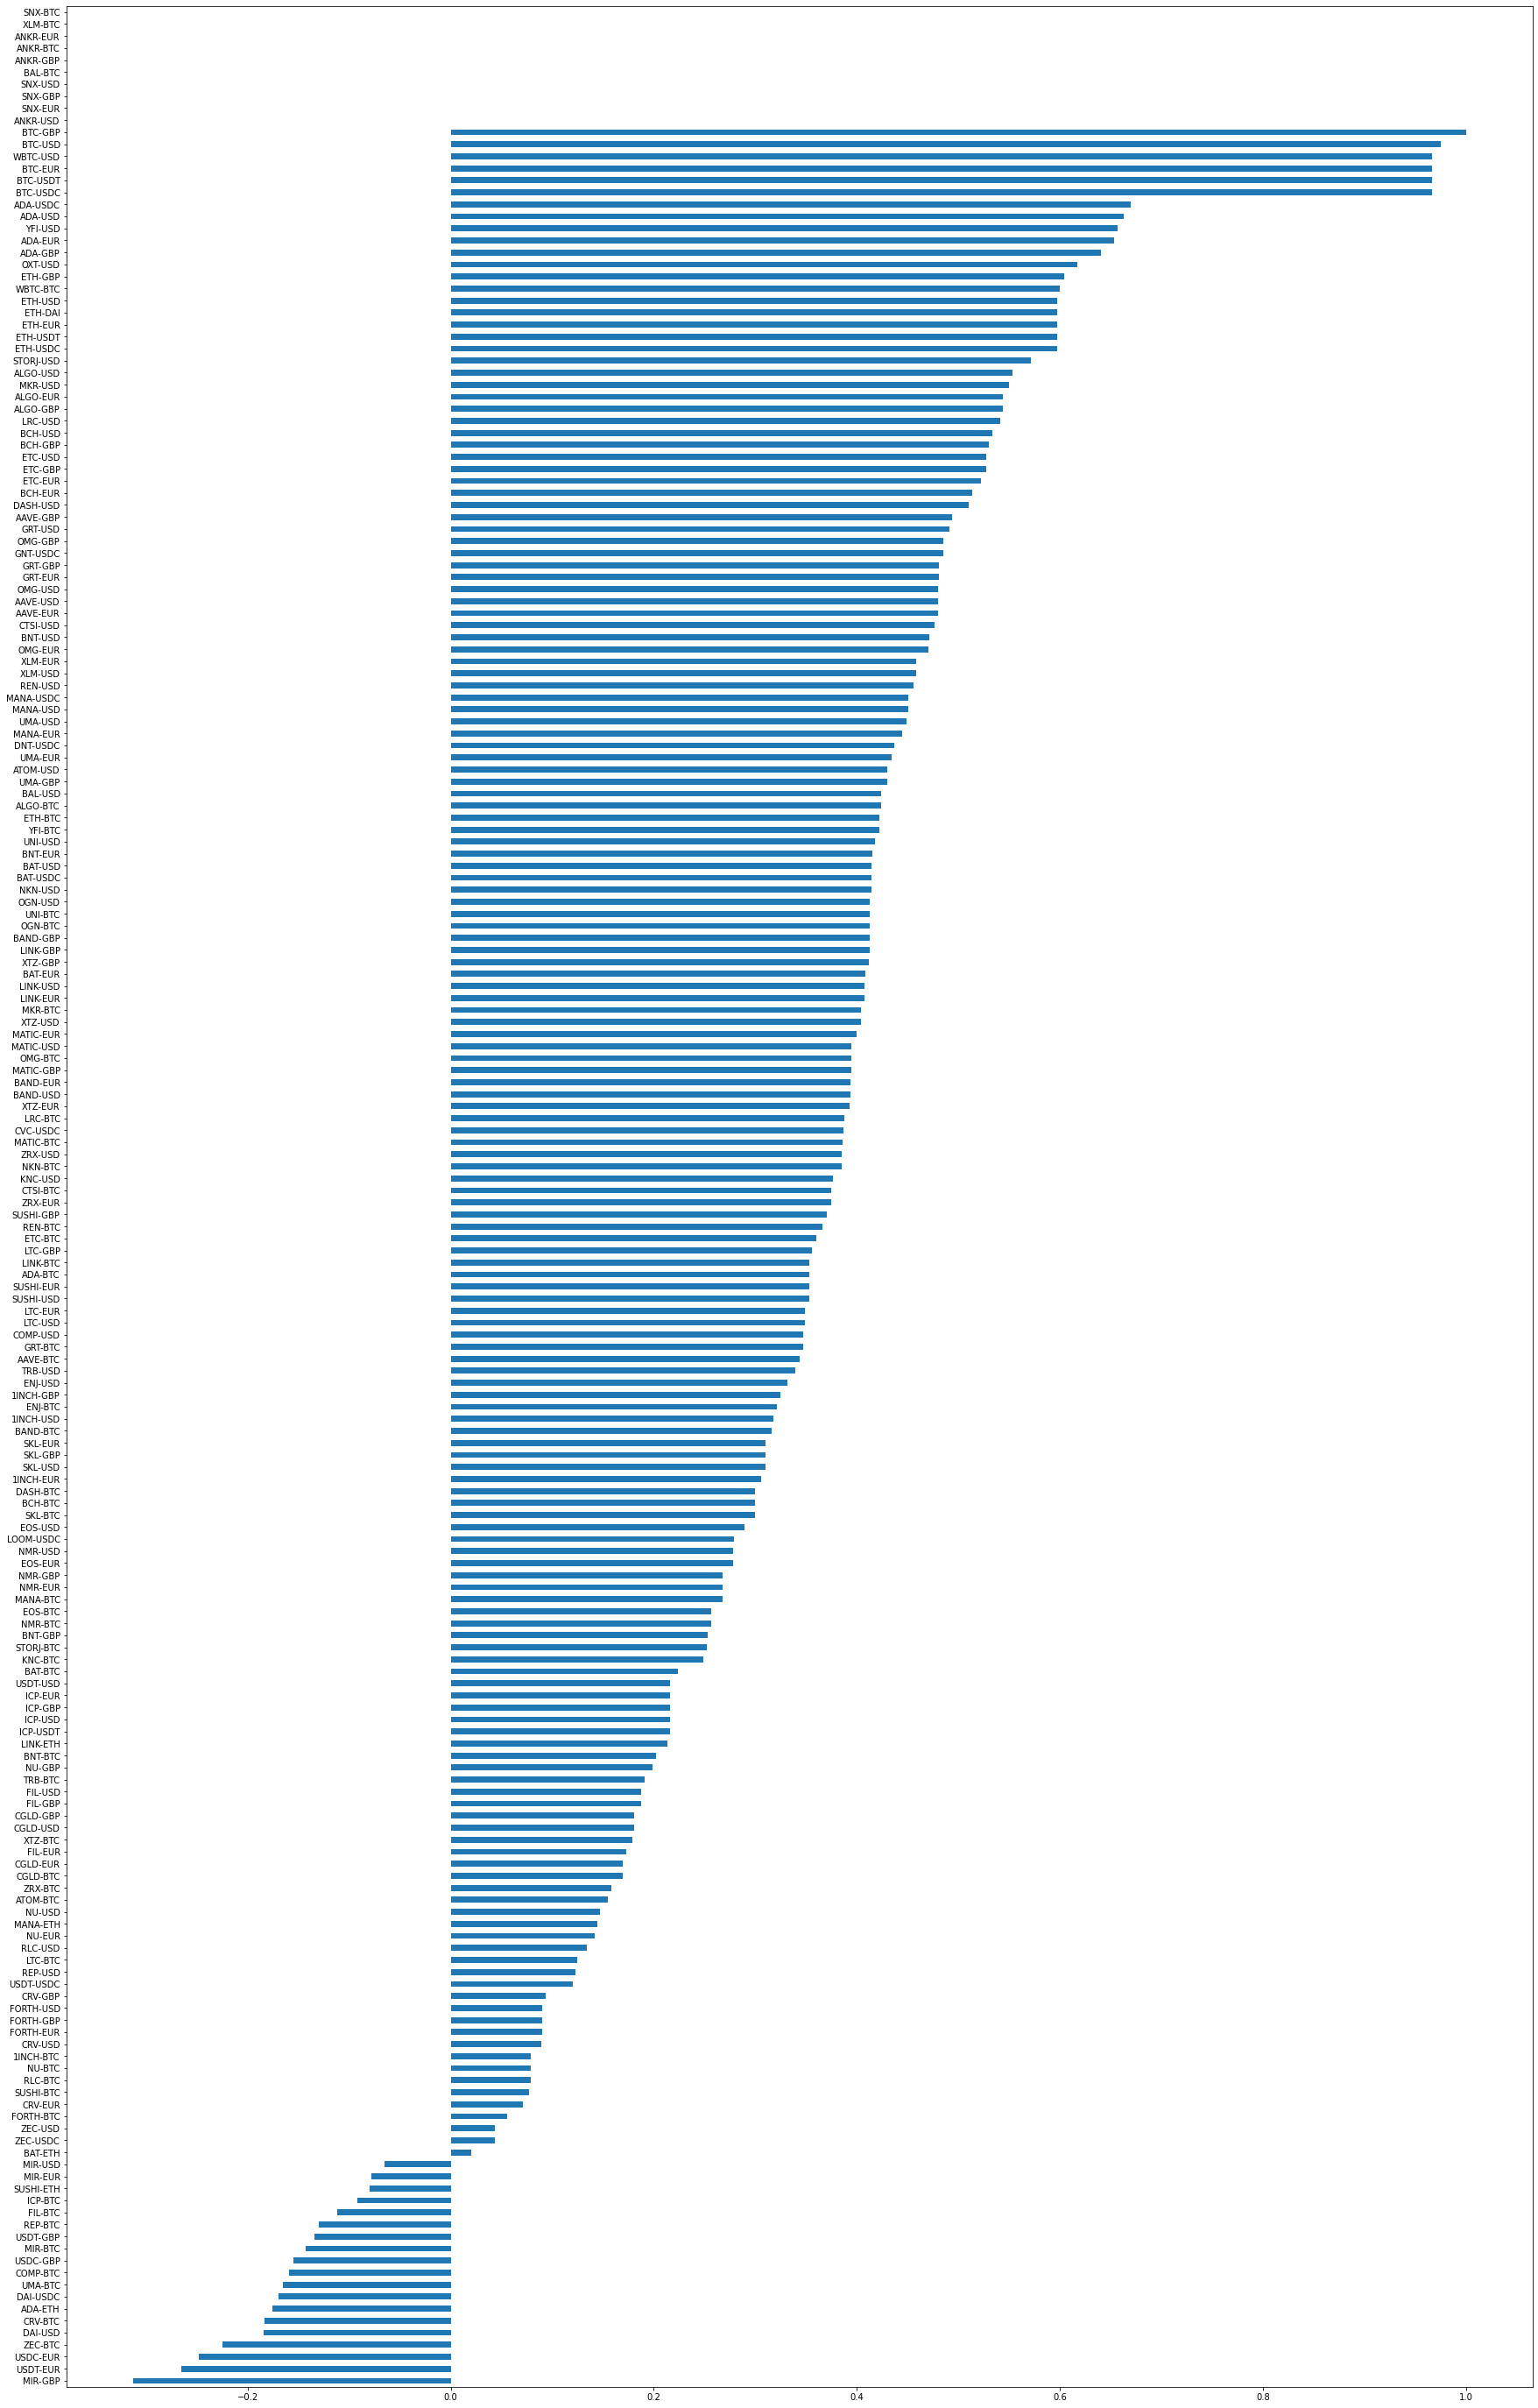

In [70]:
figure(figsize=(30,50))
df_transpose = df.T
df_transpose.corr()['BTC-GBP'].sort_values(ascending=True).plot(kind='barh')
savefig('coinbasepro_market_analysis.jpg')

In [97]:
top_10 = df_transpose.corr()['BTC-GBP'].sort_values(ascending=False).keys()[0:20]
print (top_10)

Index(['BTC-GBP', 'BTC-USD', 'WBTC-USD', 'BTC-EUR', 'BTC-USDT', 'BTC-USDC',
       'ADA-USDC', 'ADA-USD', 'YFI-USD', 'ADA-EUR', 'ADA-GBP', 'OXT-USD',
       'ETH-GBP', 'WBTC-BTC', 'ETH-USD', 'ETH-DAI', 'ETH-EUR', 'ETH-USDT',
       'ETH-USDC', 'STORJ-USD'],
      dtype='object')


In [96]:
bottom_10 = df_transpose.corr()['BTC-GBP'].sort_values(ascending=True).keys()[0:20]
print (bottom_10)

Index(['MIR-GBP', 'USDT-EUR', 'USDC-EUR', 'ZEC-BTC', 'DAI-USD', 'CRV-BTC',
       'ADA-ETH', 'DAI-USDC', 'UMA-BTC', 'COMP-BTC', 'USDC-GBP', 'MIR-BTC',
       'USDT-GBP', 'REP-BTC', 'FIL-BTC', 'ICP-BTC', 'SUSHI-ETH', 'MIR-EUR',
       'MIR-USD', 'BAT-ETH'],
      dtype='object')


In [117]:
df_filtered = df[~df_transpose.keys().str.contains('USD[TC]', regex=True)]
df_filtered_transpose = df_filtered.T

In [118]:
bottom_filtered_10 = df_filtered_transpose.corr()['BTC-GBP'].sort_values(ascending=True).keys()[0:20]
print (bottom_filtered_10)

Index(['MIR-GBP', 'ZEC-BTC', 'DAI-USD', 'CRV-BTC', 'ADA-ETH', 'UMA-BTC',
       'COMP-BTC', 'MIR-BTC', 'REP-BTC', 'FIL-BTC', 'ICP-BTC', 'SUSHI-ETH',
       'MIR-EUR', 'MIR-USD', 'BAT-ETH', 'ZEC-USD', 'FORTH-BTC', 'CRV-EUR',
       'SUSHI-BTC', 'RLC-BTC'],
      dtype='object')
